# Regularização

Regularização consiste em evitar que ocorra overfit dos dados. Veremos algumas técnicas populares de regularização.

In [15]:
import torch
from torch import nn
from dataset import load_fashion_mnist_small
import train

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(28*28, 16),
            nn.Linear(16, 16),
            nn.Linear(16, 16),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return self.layers(x)

# Dataset fashion MNIST com apenas 1 imagem por classe no conjunto de treinamento
ds_train, ds_valid = load_fashion_mnist_small(n_train=10)


### Treinamento com overfit
Os gráficos mostram bem o sobreajuste (overfit), mostrando que, após algumas épocas de treinamento, o modelo começa a perder validação (loss de validação começa a aumentar). O modelo nao consegue aprender os padrões, está simplesmente piorando, por mais que ele varra todo o dataset. Também é possível ver isso quando a acurácia começa a cair.

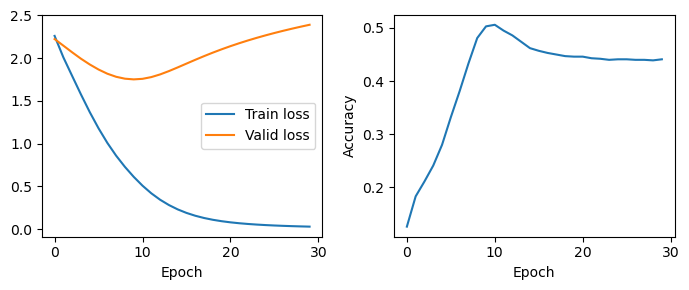

CPU times: user 12 s, sys: 140 ms, total: 12.2 s
Wall time: 4.16 s


In [16]:
%%time
torch.random.manual_seed(0) # Passando um seed para sempre ter os mesmos itens.
model = Model()
bs = 10 # batch size
num_epochs = 30
lr = 0.1 # learning rate
weight_decay = 0.

logger = train.train(model, ds_train, ds_valid, bs = bs, num_epochs = num_epochs, lr = lr, 
                     weight_decay = weight_decay)
train.show_log(logger)

### Regularização L2 (weight decay)
O weight decay é utilizado para que o modelo não tenha derivadas muito altas. Quanto maior o valor, mais suave a função, permitindo que o modelo se ajuste por mais tempo.

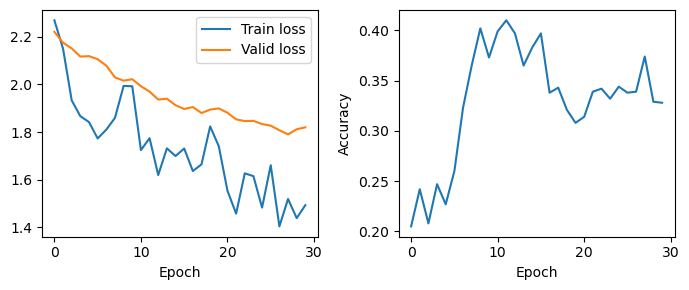

CPU times: user 21.3 s, sys: 227 ms, total: 21.5 s
Wall time: 7.34 s


In [27]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs = bs, num_epochs = num_epochs, lr = lr, 
                     weight_decay = 0.4)
train.show_log(logger)

### Efeito de regularização do batch size

Treinamento a rede com um batch size menor também possui um efeito de regularização

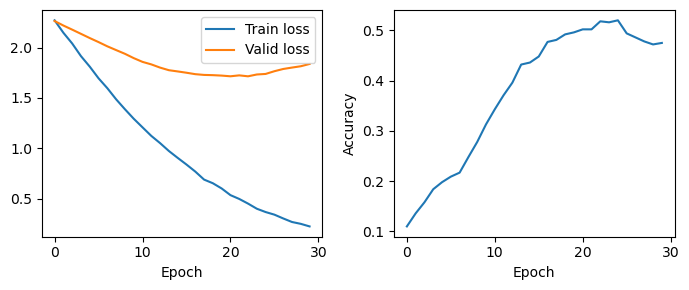

CPU times: user 14.7 s, sys: 178 ms, total: 14.9 s
Wall time: 5.02 s


In [18]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs = 2, num_epochs = num_epochs, lr = 0.01, 
                     weight_decay = weight_decay)
train.show_log(logger)

### Dropout

#### Entendendo a camada Dropout

A camada dropout remove aleatoriamente alguns valores de entrada. Mas após a remoção o resultado de operações após a camada podem acabar reduzindo de valor. Para evitar isso, a camada reescala os valores.

In [19]:
probability = 0.5
drop = nn.Dropout(probability)
x = torch.tensor([1, 2, 3, 4, 5, 6], dtype=torch.float32)
y = drop(x)
print(y)

tensor([ 0.,  4.,  6.,  8.,  0., 12.])


In [20]:
# Remove os mesmos valores que a camada Dropout acima
x_drop = x * (y > 0)
# Reescala os valores
yc = x_drop / (1 - probability)
print(yc)

tensor([ 0.,  4.,  6.,  8.,  0., 12.])


In [21]:
drop.eval()
y = drop(x)
print(y)

tensor([1., 2., 3., 4., 5., 6.])


#### Adicionando Dropout ao modelo

É útil adicionar o dropout logo antes da camada de classificação (última camada). A ideia é a seguinte: o dropout evita que a camada de classificação use sempre os mesmos atributos extraídos para fazer a classificação das imagens. 

Dropout possui uma analogia com a técnica de **boosting** em machine learning. Para a rede ter boa performance, ela precisa ter diversas "subredes" que classificam bem as imagens, pois atributos são aleatoriamente apagados. 

Em redes convolucionais, não é comum adicionar dropout, visto que os campos próximos tendem a ser parecidos.

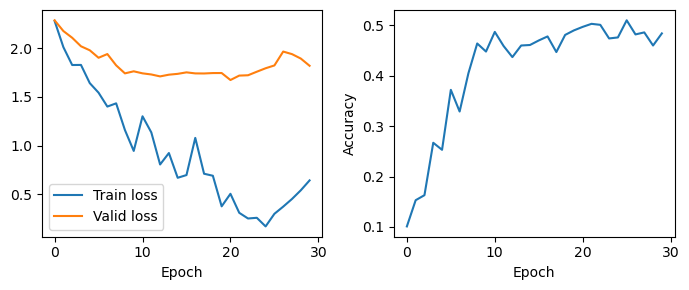

CPU times: user 12.5 s, sys: 149 ms, total: 12.7 s
Wall time: 4.28 s


In [22]:
%%time
class ModelDrop(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(28*28, 16),
            nn.Linear(16, 16),
            nn.Linear(16, 16),
            nn.Dropout(0.5), # Dropout evita que use sempre os mesmos atributos
            nn.Linear(16, 10) # Camada de classificação.
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return self.layers(x)

torch.random.manual_seed(0)
model = ModelDrop()

logger = train.train(model, ds_train, ds_valid, bs=bs, num_epochs=num_epochs, lr=lr, 
                     weight_decay=weight_decay)
train.show_log(logger)

### Aumento de dados

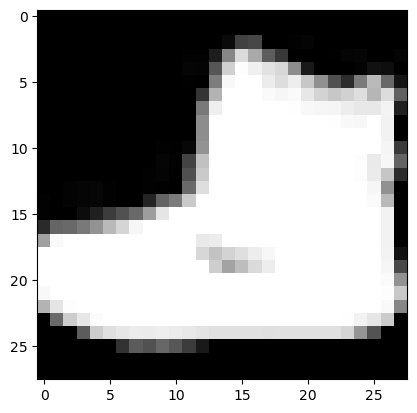

In [41]:
import matplotlib.pyplot as plt

#ds_train.transform = partial(augment_mnist, mean=73., std=81.7)
ds_train, ds_valid = load_fashion_mnist_small(n_train = 10, augment = True)
plt.imshow(ds_train[0][0][0], 'gray')

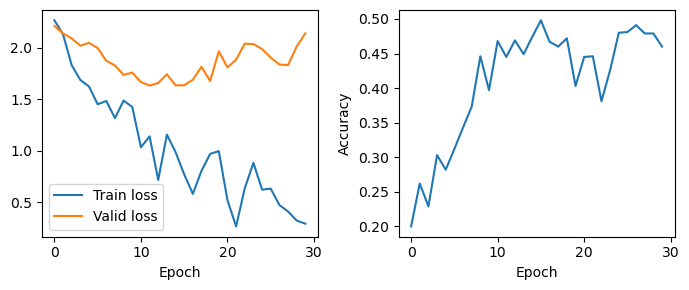

CPU times: user 22.4 s, sys: 188 ms, total: 22.6 s
Wall time: 7.7 s


In [24]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs = bs, num_epochs = num_epochs, lr = lr, 
                     weight_decay = weight_decay)
train.show_log(logger)

### Unindo todas as técnicas

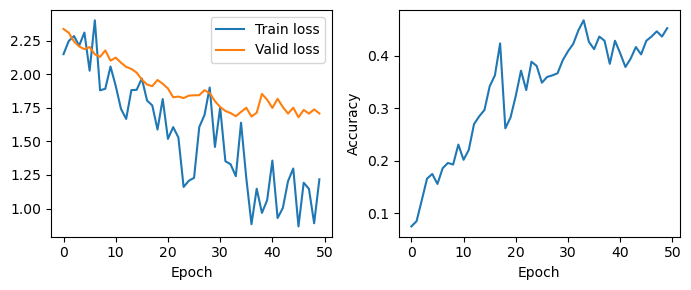

In [44]:
torch.random.manual_seed(0)
model = ModelDrop()

logger = train.train(model, ds_train, ds_valid, bs = 8, num_epochs = 50, lr = 0.02, 
                     weight_decay = 0.01)
train.show_log(logger)